In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.isotonic import IsotonicRegression

In [3]:
plt.style.use('dark_background')

### Compute risk metrics

In [4]:
risk_window_size = 60

In [5]:
df_pred = pd.read_pickle(r'D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\df_test_mestrado.pkl')
df_pred = df_pred[['asset_identifier', 'date', 'yhat', 'target']]

In [6]:
df_prices = pd.read_pickle(r"D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\full_market_data_final.pkl")
df_prices = df_prices[['asset_identifier', 'ric', 'date', 'close', 'universe']].copy()
df_prices.loc[:, 'ret'] = df_prices.groupby('asset_identifier')['close'].pct_change()
df_prices.loc[:, 'vol'] = df_prices.groupby('asset_identifier')['ret'].apply(lambda x: x.rolling(risk_window_size).std())
df_prices.dropna(inplace = True)

In [7]:
df_ibov = pd.read_csv(r"D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\^BVSP.csv")
df_ibov.dropna(inplace = True)
df_ibov.rename(columns = {"Date": 'date', 'Close': 'ibov_close'}, inplace = True)
df_ibov = df_ibov[['date', 'ibov_close']]
df_ibov.loc[:, 'date'] = pd.to_datetime(df_ibov['date'])
df_ibov.loc[:, 'ibov_ret'] = df_ibov['ibov_close'].pct_change()
df_ibov.loc[:, 'ibov_vol'] = df_ibov['ibov_ret'].rolling(risk_window_size).std()

In [8]:
df_full = df_prices.merge(df_pred, on = ['asset_identifier', 'date'], how = 'left')
df_full = df_full.merge(df_ibov, on = ['date'], how = 'inner')
start_date = df_pred['date'].min()
end_date = df_pred['date'].max()
df_full.query("date >= @start_date & date <= @end_date", inplace = True)

df_full.loc[:, 'asset_identifier'] = df_full['asset_identifier'].astype(str)
df_full.sort_values(['asset_identifier', 'date'], inplace = True)

In [9]:
def rolling_corr(data):
    col1, col2 = data.columns
    if len(data) > risk_window_size:
        rolling_covariances = data.rolling(risk_window_size, min_periods = 2).corr().fillna(0)
        rolling_covariances.reset_index(level = 0, drop = True, inplace = True)
        rolling_covariances = rolling_covariances.loc[col1, col2]
        rolling_covariances[(rolling_covariances == np.Inf) | (rolling_covariances == -np.Inf)] = 0
        return rolling_covariances
    else:
        return pd.Series([0]  * len(data))

In [10]:
list_df = []
for asset, data in df_full.groupby('asset_identifier'):
    data.loc[:, 'ibov_correlation'] = rolling_corr(data[['ret', 'ibov_ret']]).values
    data.eval("ibov_beta = ibov_correlation * vol/ibov_vol", inplace = True)
    list_df.append(data)
df_full = pd.concat(list_df)

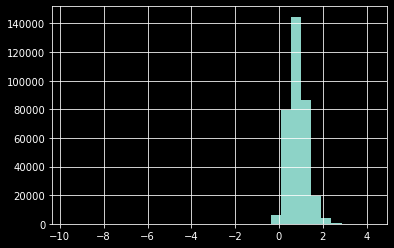

In [11]:
df_full.query("universe").eval('ibov_beta').hist(bins = 30);

<AxesSubplot:>

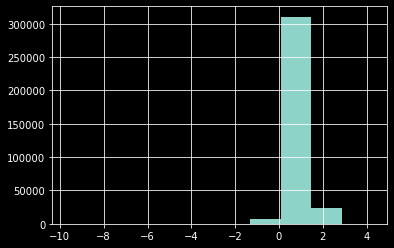

In [12]:
df_full.query("universe").eval('ibov_beta').hist()

### Calibrate

In [13]:
split_date = '2016-01-01'

In [14]:
df_train = df_full.query("universe & date < @split_date").dropna().copy()
df_test = df_full.query("date > @split_date").copy()

In [15]:
calibrator = IsotonicRegression()
calibrator.fit(df_train['yhat'], df_train['target'])

IsotonicRegression()

In [16]:
df_train.loc[:, 'calibrated_yhat'] = calibrator.predict(df_train['yhat'])
df_test.loc[:, 'calibrated_yhat'] = calibrator.predict(df_test['yhat'].fillna(0))

In [17]:
df_test[['calibrated_yhat', 'target']].corr()

,calibrated_yhat,target
calibrated_yhat,1.00000,0.00657
target,0.00657,1.00000


In [18]:
df_train[['calibrated_yhat', 'target']].corr()

,calibrated_yhat,target
calibrated_yhat,1.000000,0.060586
target,0.060586,1.000000


In [19]:
df_train[['ibov_beta', 'target']].corr()

,ibov_beta,target
ibov_beta,1.000000,-0.004491
target,-0.004491,1.000000


In [20]:
df_train[['vol', 'target']].corr()

,vol,target
vol,1.000000,0.000524
target,0.000524,1.000000


In [21]:
df_train.date.min()

Timestamp('2008-01-02 00:00:00')

In [22]:
data = (df_train, df_test)
pd.to_pickle(data, r'D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\data_mestrado.pkl')